# **Aumentiamo il contesto: N-Gram Language Model**
### **Sviluppo di Makemore, Parte 2**
Dennis Remigio, Luglio 2024

**Obiettivi**: Sviluppare e addestrare un N-Gram Language Model capace di generare nomi. Fornire basi su concetti fondamentali come l'embedding, batching, learning rate e modifica di parametri e iperparametri.

**Precompetenze**: basi di Python, comprensione di base della struttura delle reti neurali e del loro addestramento, conoscenza del metodo di one hot encoding, conoscenza delle regole di broadcasting  

&nbsp;

---

Adattamento e approfondimento della lezione di **Andrej Karpathy, PhD**: *Building makemore Part 2: MLP*, disponibile [qui](https://youtu.be/TCH_1BHY58I?si=jBRFtd6GilOJgB5F).

---

## **Indice**

[**Introduzione**](#s0)  
[**1 - Struttura della rete**](#s1)  
[**2 - Embedding**](#s2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**2.1 - Encoding e decoding**](#s2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**2.2 - Contesto e labelling**](#s2.2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**2.3 - Tabella di look-up**](#s2.3)  
[**3 - Definizione dello strato nascosto**](#s3)  
&nbsp;&nbsp;&nbsp;&nbsp;[**3.1 - Moltiplicazione tra input e pesi: funzione `cat()`**](#s3.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**3.2 - Moltiplicazione tra input e pesi: funzione `view()`**](#s3.2)  
[**4 - Output layer, logits e calcolo della perdita**](#s4)  
[**5 - Efficientamento del codice**](#s5)  
&nbsp;&nbsp;&nbsp;&nbsp;[**5.1 - Calcolo della perdita: funzione `cross_entropy()`**](#s5.1)  
[**6 - Addestramento:**](#s6)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.1 - Batching**](#s6.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.2 - Learning rate**](#s6.2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[**6.2.1 - Learning rate decay**](#s6.2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.3 - Scomposizione del dataset in Train, Validation e Test**](#s6.3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[**6.3.1 - Grafico della matrice di embedding post addestramento**](#s6.3.1)  
[**7 - Generazione di nomi**](#s7)  
[**Conclusioni**](#s8)  

<a name="s0"></a>
## **Introduzione**

In questa lezione, seguendo l'articolo [***A Neural Probabilistic Language Model*** *(Bengio et al. 2003)*](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), creeremo un N-Gram Language Model.  

La lezione segue e approfondisce i concetti affrontati nella lezione precedente (in cui abbiamo creato un **Bigram Language Model**, sia attraverso il conteggio di tutte le combinazioni possibili dei bigram, sia tramite l'addestramento di una rete neurale). In questa lezione approfondiremo un possibile metodo per far considerare al modello più di due caratteri alla volta, riducendo la perdita del modello e ottenendo generazioni qualitativamente migliori.

Nella lezione precedente, abbiamo visto che era possibile creare un modello senza addestrare una rete neurale, ma individuando tutte le combinazioni dei bigram all'interno del dataset fornito, e calcolando quindi una distribuzione di probabilità. In questa lezione, ciò diventerebbe rapidamente impraticabile, poiché, per ogni carattere aggiunto come contesto, le combinazioni aumentano esponenzialmente.  

Creeremo dunque un MLP (Multy-Layer Perceptron), procedendo poi con l'ottimizzazione dei gradienti per ridurre la perdita del modello.



Il funzionamento del modello di linguaggio che svilupperemo può essere spiegato attraverso i seguenti punti:

1. **Individuazione degli elementi**: inizialmente, identifichiamo tutti gli elementi di base del nostro modello. Nel caso specifico di un modello basato sui caratteri, questi elementi sono i singoli caratteri dell'alfabeto, per un totale di 27 caratteri (includendo il carattere che definisce l'inizio e la fine del nome).  

2. **Embedding**: il prossimo passo è rappresentare ciascun carattere come un punto in uno spazio vettoriale multidimensionale. Questo processo è noto come embedding. Ad esempio, possiamo immaginare uno spazio di due dimensioni dove ogni carattere viene posizionato come un punto specifico in un piano cartesiano. Inizialmente la rappresentazione viene effettuata in modo casuale.

3. **Ottimizzazione e relazioni**: durante l'addestramento del modello, avviene il processo di ottimizzazione (forward pass e back propagation per la minimizzazione della perdita) in cui il modello apprende le relazioni tra i vari caratteri. Questo significa che i caratteri che tendono ad apparire vicini tra loro in un testo (come "t" e "h" nella parola "the") verranno rappresentati come punti vicini nello spazio vettoriale. Il modello modifica quindi la posizione dei punti nello spazio per riflettere queste relazioni.

4. **Previsione**: una volta addestrato, il modello può fare previsioni anche su sequenze di caratteri che non ha visto durante l'addestramento. Quando incontra un carattere sconosciuto, il modello può guardare i punti vicini nello spazio vettoriale e utilizzare queste informazioni per effettuare una previsione il più possibile coerente.

&nbsp;

---

Questo approccio vale allo stesso modo considerando le parole al posto dei caratteri. In tale caso, avverrà il word embedding (al posto del character embedding), in cui saranno le parole ad essere trasformate in punti nello spazio vettoriale, e parole con significati simili, o che vengono utilizzate in contesti simili, si troveranno relativamente vicine in tale spazio.

---

<a name="s1"></a>
## **1 - Struttura della rete**

La rete che vogliamo creare è strutturata come segue:

1. **Input**: nel nostro caso saranno 27, ovvero il numero dei caratteri, includendo anche il carattere speciale che indica il termine
 e l'inizio della parola (nel documento, che invece è strutturato in base alle parole che costituiscono il vocabolario, sono oltre 17000).  

2. **Tabella di look-up**: ogni carattere verrà convertito in un vettore di embedding, di N dimensioni (il numero di dimensioni verrà scelto da noi, generalmente vengono utilizzate più dimensioni man mano che gli input sono numerosi, nel nostro caso, probabilmente, sarà sufficiente utilizzare 2 o 3 dimensioni). Se, ad esempio, utilizzassimo 2 dimensioni, ci sarebbe una tabella composta da 27 righe e 2 colonne, e ad ogni carattere corrisponderà una riga che rappresenterà il suo vettore di embedding. In questo esempio, tale passaggio porterebbe ad avere `27*2 = 54` neuroni per il primo input layer. La matrice `C` (ovvero la tabella di look-up) è condivisa tra i vari caratteri, in quanto ogni carattere avrà un suo embedding vector.

3. **Primo strato nascosto**: la dimensione di questo strato è un iperparametro (hyperparameter), ovvero un parametro a discrezione del designer della rete neurale. La modifica di questo iperparametro può portare a differenti risultati, quindi andranno effettuati diversi test per ottimizzare i risultati (poi vedremo come). Questo layer è completamente connesso al layer di input, perciò ogni neurone di questo strato riceverà tutti gli input dallo strato di input.

4. **Output layer**: la dimensione sarà data, nel nostro caso, dal numero di caratteri, ovvero 27 (nel caso delle parole, sarebbe stata di oltre 17000). L'output seguirà la funzione SoftMax che trasformerà i valori in una distribuzione di probabilità.  
Nella fase di training, ogni carattere avrà un suo label (etichetta), che fornirà al modello l'informazione su quale probabilità andrebbe aumentata per ridurre la perdita e migliorare le prestazioni tramite backpropagation e ottimizzazione dei gradienti.

&nbsp;

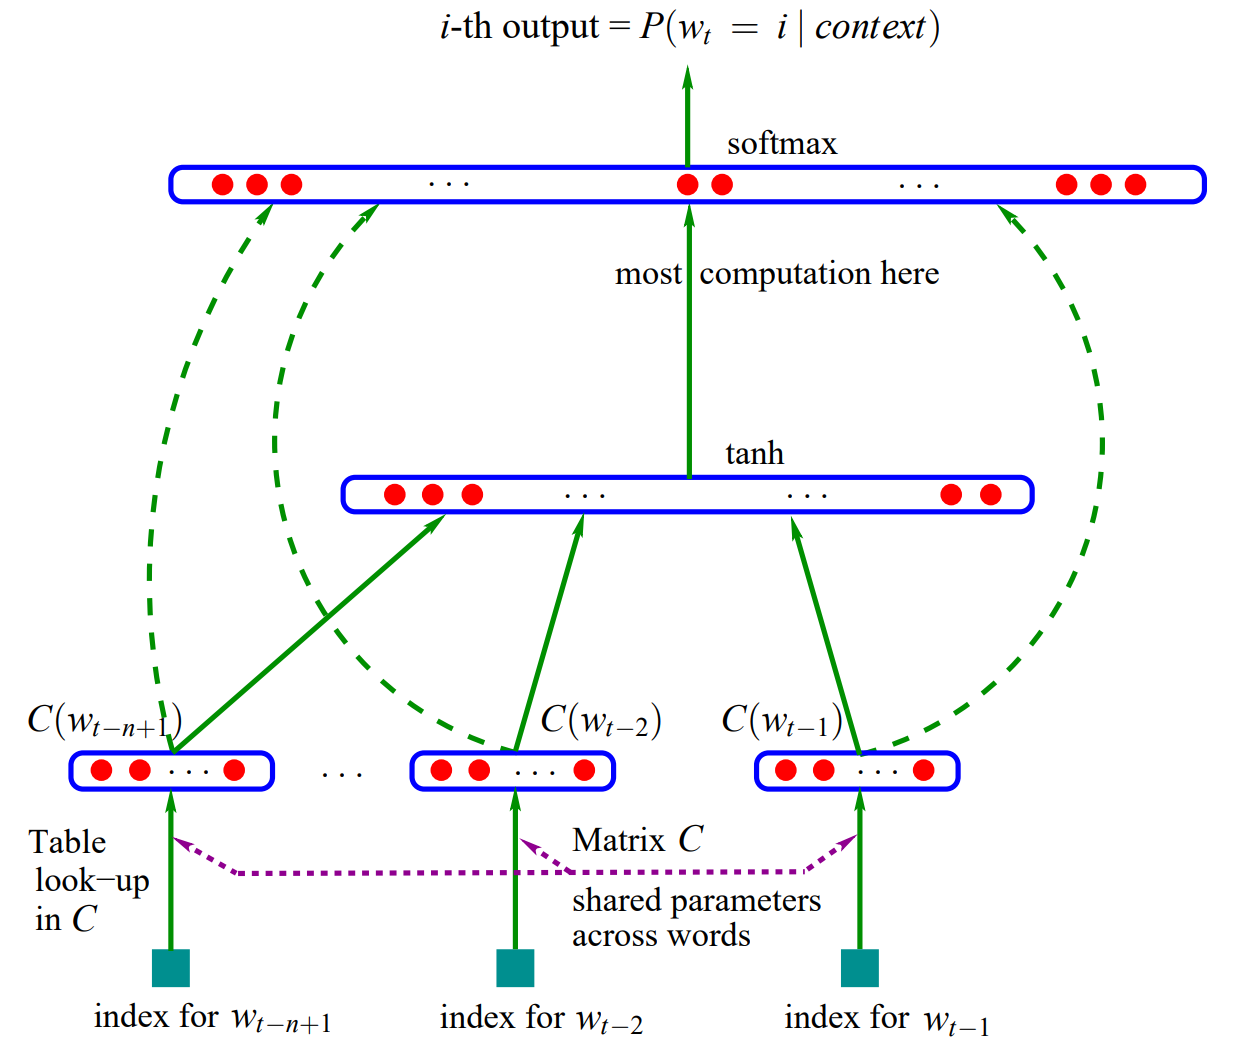


I parametri di questa rete saranno i pesi e i bias del layer nascosto, e i pesi e i bias dell'output layer.  


<a name="s2"></a>
## **2 - Embedding**

In questo capitolo ci focalizzeremo su tutto il processo necessario ad effettuare l'embedding dei caratteri. Inizialmente, faremo in modo di convertire le lettere in numeri (processo di encoding), poi proseguiremo con il definire la matrice `X` degli input e il vettore `Y` di ciò che si vuole prevedere (ovvero l'etichetta corrispondente a ciascun input che, nel caso del Bigram Language Model era un singolo carattere, mentre in questo caso è l'insieme di caratteri definiti dal contesto scelto). 

Infine, si passerà ad effettuare il processo di embedding vero e proprio, ovvero a convertire ciascun carattere in un vettore, nel nostro caso di due elementi (poiché, inizialmente, effettueremo le varie prove effettuando un embedding in sole 2 dimensioni). Inizialmente, i valori di ciascun vettore saranno definiti in maniera casuale, ma, a seguito dell'addestramento, i valori cambieranno, indicando che il modello ha individuato delle relazioni tra i vari caratteri. Analizzando i vari vettori sarà infatti possibile notare che caratteri simili (per natura, per modalità di utilizzo o altre ragioni) avranno vettori con valori simili. Nel nostro caso, visto che stiamo effetuando un embeddin in vettori di due elementi, potremo rappresentare i vettori di ciascun carattere in un piano cartesiano e vedere in maniera diretta come il modello considera i vari caratteri (queste osservazioni le faremo nelle ultime parti della lezione).

<a name="s2.1"></a>
### **2.1 - Encoding e decoding**

Iniziamo importando le librerie fondamentali

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # per generare grafici
%matplotlib inline

Importiamo successivamente il file che utilizzeremo per questa lezione, ovvero lo stesso della lezione precedente (lista di nomi).

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-06-28 18:53:33--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-06-28 18:53:33 (10.3 MB/s) - ‘names.txt’ saved [228145/228145]



Trasformiamo la lista di nomi in un vettore in cui ogni nome costituisce un elemento.

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Possiamo vedere che sono presenti 32033 nomi in questo dataset.

In [ ]:
len(words)

32033

Come fatto per il Bigram Language Model, creiamo il codice per l'encoding e il decoding di ciascun carattere (molto sempicmenente, in numeri da `1` a `27`, includendo anche il `.` come carattere numero `0`).

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


<a name="s2.2"></a>
### **2.2 - Contesto e labelling**

Ora vediamo come abbiamo intenzione di etichettare i valori. In questo esempio, utilizzeremo `3` caratteri come contesto per la generazione del quarto (rispetto al bigram language model che ne aveva solo `1`, questo dovrebbe portare ad un netto miglioramento delle prestazioni del modello).

In [ ]:
# build the dataset
block_size = 3 # contesto: quanti caratteri consideriamo per poter prevedere il seguente

X, Y = [], []
for w in words[:3]: # per l'esempio consideriamo solamente le prime 3 parole

  print(w) # scrive la parola corrente per intero
  context = [0] * block_size # inizializziamo i caratteri di contesto con un vettore di 3 elementi (inizialmente [0, 0, 0], ovvero 3 volte il carattere '.')
  for ch in w + '.': # per ogni carattere di una data parola (alla quale viene aggiunto manualmente un punto alla fine)
    ix = stoi[ch] # viene individuato il numero del carattere corrente (valore dato dall'encoding)
    X.append(context) # aggiungiamo ad X il valore del contesto attuale (inizialmente quindi si avrà [0, 0, 0])
    Y.append(ix) # aggiungiamo ad Y il numero del carattere corrente
    print(''.join(itos[i] for i in context), '--->', itos[ix]) # scrive le lettere presenti nel contesto (quindi inizialmente converte [0, 0, 0] in '...'), seguita da una freccia e la lettera corrente
    context = context[1:] + [ix] # viene tagliato il primo elemento del contesto , e si fa l'append con il numero del carattere attuale (quindi per il primo giro in questo esempio si passa da [0, 0, 0] a [0, 0, 5])

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .


Possiamo analizzare i dati attuali, ottenuti considerando solamente le prime `3` parole.

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

Vediamo che il dataset è formato da `16` esempi (considerando solo le prime `3` parole), ed ogni input `X` alla rete neurale è fatto da `3` numeri interi (`int`).  

È inoltre presente `Y`, che rappresenta i label, che sono in totale `16`.

In [ ]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]])

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

Costruiamo quindi una rete neurale che prende in input le `X` e predice le `Y`.

<a name="s2.3"></a>
### **2.3 - Tabella di look-Up**

Nel documento da cui stiamo prendendo riferimento, viene effettuato l'embedding di 17000 parole in uno spazio vettoriale di 30 dimensioni. Nel nostro caso, poiché abbiamo solamente 27 caratteri, effettueremo un embedding in uno spazio vettoriale di sole 2 dimensioni.  

L'obiettivo di effettuare l'embedding è di scomporre una informazione in più parti (sarebbe come scomporre un determinato colore nei colori primari che lo compongono) in modo che il sistema, tramite l'addestramento, possa comprendere come l'elemento è relazionato ad altri.

Definiamo ora la tabella di look up (`C`), che inizialmente ha valori casuali al suo interno, e verrà in seguito ottimizzata tramite l'addestramento.

In [ ]:
C = torch.randn((27, 2))
C

tensor([[ 0.1365,  1.9290],
        [ 0.6803, -0.6909],
        [-0.2438,  0.1504],
        [ 0.4734, -1.6406],
        [ 1.1636, -0.3852],
        [ 3.1188,  0.9540],
        [-0.5584,  0.9775],
        [-1.8017, -0.4775],
        [-0.5382, -0.8392],
        [-1.0231, -1.0667],
        [-0.8715,  0.4696],
        [ 1.4611,  0.2253],
        [-0.0694, -0.9621],
        [ 1.2248, -1.0539],
        [ 1.4987,  0.5401],
        [ 0.2790,  0.1146],
        [ 1.4451,  0.1103],
        [ 0.0339,  0.7400],
        [-0.4949,  1.1871],
        [-0.8520,  0.0759],
        [-0.6980, -0.5812],
        [ 2.1201,  0.3198],
        [-0.1074,  1.7135],
        [ 0.6164, -0.8577],
        [ 1.0939, -0.1937],
        [ 0.3074, -3.6817],
        [-0.2625, -1.2257]])

Prima di effettuare l'embedding di tutte le lettere, proviamo con una sola, in modo da capire bene come funziona il processo.

Nella lezione precedente abbiamo visto come sia possibile effettuare inizialmente un encoding (one hot encoding) dei caratteri, e poi effettuare il prodotto vettoriale con `C`.

Facciamo un esempio con il quinto carattere:

In [ ]:
(F.one_hot(torch.tensor(5), 27)).float() @ C # one hot encoding sul numero 5, in un vettore di 27 elementi, viene poi reso float e viene fatto il prodotto vettoriale con "C"

tensor([3.1188, 0.9540])

Per via della struttura del vettore ottenuto con il one hot encoding, questo passaggio equivale a selezionare il quinto valore di `C`, come possiamo vedere facilmente:

In [ ]:
C[5]

tensor([3.1188, 0.9540])

Poiché il risultato è equivalente, utilizzeremo questo secondo metodo, in quanto è più rapido.

&nbsp;

---

Questo confronto ci permette di capire che la fase di embedding può essere considerata anche come un primo layer della rete, che riceve in input i caratteri (a seguito del processo di one hot encoding), e moltiplica i "pesi" dati dalla matrice `C`.

---

&nbsp;

Ora possiamo pensare a come effettuare l'embedding per tutti gli input `X`. Per via della struttura di `C` (che, ricevendo in input il numero del carattere, restituisce direttamente il valore della riga corrispondente della matrice `C`), si può fare molto semplicemente.

In [ ]:
emb = C[X]
emb

tensor([[[ 0.1365,  1.9290],
         [ 0.1365,  1.9290],
         [ 0.1365,  1.9290]],

        [[ 0.1365,  1.9290],
         [ 0.1365,  1.9290],
         [ 3.1188,  0.9540]],

        [[ 0.1365,  1.9290],
         [ 3.1188,  0.9540],
         [ 1.2248, -1.0539]],

        [[ 3.1188,  0.9540],
         [ 1.2248, -1.0539],
         [ 1.2248, -1.0539]],

        [[ 1.2248, -1.0539],
         [ 1.2248, -1.0539],
         [ 0.6803, -0.6909]],

        [[ 0.1365,  1.9290],
         [ 0.1365,  1.9290],
         [ 0.1365,  1.9290]],

        [[ 0.1365,  1.9290],
         [ 0.1365,  1.9290],
         [ 0.2790,  0.1146]],

        [[ 0.1365,  1.9290],
         [ 0.2790,  0.1146],
         [-0.0694, -0.9621]],

        [[ 0.2790,  0.1146],
         [-0.0694, -0.9621],
         [-1.0231, -1.0667]],

        [[-0.0694, -0.9621],
         [-1.0231, -1.0667],
         [-0.1074,  1.7135]],

        [[-1.0231, -1.0667],
         [-0.1074,  1.7135],
         [-1.0231, -1.0667]],

        [[-0.1074,  1

Possiamo infatti vedere che `emb` è strutturato come un vettore di dimensione `16x3x2` (`16` è dato dal numero di esempi `X`, `3` è dato dal numero di lettere di contesto e `2` è dato dalla dimensionalità che abbiamo scelto per l'embedding).

In [ ]:
emb.shape

torch.Size([16, 3, 2])

<a name="s3"></a>
## **3 - Definizione dello strato nascosto**

<a name="s3.1"></a>
### **3.1 - Moltiplicazione tra input e pesi: funzione `cat()`**

Procediamo ora con la definizione dell'hidden layer, con pesi inizializzati in maniera casuale. Il numero di pesi dipende dall'input: nel nostro caso, ogni neurone riceverà `3x2 = 6` input (poiché il contesto è di `3` caratteri, e stiamo effettuando un embedding in `2` dimensioni).

In [ ]:
W1 = torch.randn((6, 100)) # 100 indica l'iperparametro arbitrario relativo al numero di neuroni dell'hidden layer
b1 = torch.randn(100) # bias, anch'essi inizializzati casualmente, sono 100, uno per ogni neurone del layer

Ora vorremmo quindi effettuare l'operazione `emb @ W1 + b1`, ma non possiamo farla, in quanto il prodotto vettoriale non può funzionare tra un vettore di `3` dimensioni (`emb`) e uno di `2` (`W1`).  

Ci serve quindi un modo per schiacciare la terza dimensione di `emb`, concatenando i valori in qualche modo (trasformandolo da `(16, 3, 2)` in `(16, 6)`.

Fortunatamente, `PyTorch` ha una funzione che fa esattamente questo, ovvero la funzione `cat`.

&nbsp;

---

Cerchiamo inizialmente di capire cosa vorremmo ottenere, poi generalizzeremo il processo, per permettere al codice di funzionare a prescindere dal numero di caratteri scelti come contesto.

Vogliamo concatenare il valore `0`, il valore `1` e il valore `2` del secondo elemento di `emb` (in questo caso sono solamente `3`, in quanto abbiamo solamente `3` caratteri come contesto).

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # l'1 finale è perché vogliamo concatenare sulla dimensione 1, non la 0.

torch.Size([16, 6])

Come previsto, in questo modo otterremmo il risultato desiderato.

---

&nbsp;

Possiamo ora generalizzare il processo, in quanto, attualmente, se aumentassimo i caratteri di contesto dovremmo aggiungere pezzi al codice (ovvero, altri `emb[:, x, :]`).

Per generalizzare il codice, possiamo utilizzare `torch.unbind(emb, 1)`, che restituisce una lista di tensori, separati rispetto alla dimensione indicata (nel nostro caso, la dimensione `1`, ovvero le righe).

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([16, 6])

Come previsto, la forma è la stessa, ma ora è generalizzato a qualsiasi scelta del numero di caratteri di contesto.

Si da il caso che però esista un modo estremamente più efficiente di svolgere la stessa operazione.

<a name="s3.2"></a>
### **3.2 - Moltiplicazione tra input e pesi: funzione `view()`**

Per comprendere quanto segue, è necessario sapere che, per ogni tensore, viene creato uno storage di fondo, che è rappresentato come un vettore monodimensionale che ha al suo interno tutto il contenuto del tensore. E così che viene salvato nella memoria del computer.

`PyTorch` ha una funzione, chiamata `view()`, che permette di vedere un tensore nella forma che decidiamo, senza che venga effettuato alcun calcolo, quindi senza creare, modificare, copiare o spostare alcuna memoria. L'unica cosa che viene cambiata è la modalità di visualizzazione del tensore.

Possiamo quindi utilizzare questa funzione, al posto di utilizzare funzioni per concatenare. L'unica accortezza che va mantenuta sta nel fare in modo che il numero totale di elementi del tensore sia lo stesso, calcolabile facilmente tramite moltiplicazione *(`16x3x2` potrebbe essere convertito in `16x6` e non, ad esempio, in `16x4`)*.

In [ ]:
emb.view(16, 6).shape # view permette di specificare la forma in cui vogliamo vedere il tensore, nel nostro caso vogliamo che sia (16, 6)

torch.Size([16, 6])

Possiamo constatare che il risultato è lo stesso confrontando i due metodi direttamente:

In [ ]:
emb.view(16, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

Come previsto, il risultato è identico.

Possiamo ora moltiplicare gli input per i pesi, e in seguito addizionare i bias.

In [ ]:
h = emb.view(16,6) @ W1 + b1
h.shape

torch.Size([16, 100])

In questo modo, il codice funziona come sperato. Per generalizzare ancora di più, possiamo fare in modo di non dover nemmeno indicare il numero di input che arrivano al neurone (in questo caso `16`). Per farlo, è sufficiente indicare `emb.shape[0]`, oppure, utilizzando la proprietà di `view()` che impone la dimensione di essere la stessa del tensore di origine, possiamo scrivere semplicemente `-1`, e il sistema lo sostituirà in automatico nel valore necedsario a far tornare i conti.

In [ ]:
h = emb.view(-1, 6) @ W1 + b1
h.shape

torch.Size([16, 100])

&nbsp;

---

Ora, prima di continuare, dobbiamo fare attenzione ad un aspetto, che potrebbe passare inosservato e potenzialmente creare problemi in alcune situazioni.

Ciò che osserveremo è l'addizione con il bias. Se osserviamo le dimensioni dei due tensori che si sommano, possiamo vedere che non hanno la stessa forma:

In [ ]:
(emb.view(-1, 6) @ W1).shape

torch.Size([16, 100])

In [ ]:
b1.shape

torch.Size([100])

Il fatto che non siano della stessa forma fa sì che avvenga il `broadcasting` (che abbiamo studiato nella lezione precedente).

Ricordiamo quindi che, prima vengono allineati a destra, poi verrà creata una dimensione fittizia, verrà copiato verticalmente lo stesso valore (quindi su tutte le righe) e, infine, verrà fatta l'addizione riga per riga.  

In questo caso, va bene che accada ciò. Tuttavia, va tenuto in mente, perché in alcuni casi potrebbe generare problemi difficili da diagnosticare.

---

&nbsp;

<a name="s4"></a>
## **4 - Output layer, logits e calcolo della perdita**

Possiamo proseguire, definendo i pesi e i bias del layer di output.

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

Possiamo quindi calcolare i logits passando gli output dell'hidden layer a quest'ultimo.

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([16, 27])

In [ ]:
logits

tensor([[-2.2333e+01,  1.6065e+01,  8.0756e+00, -3.5380e+00,  7.0736e+01,
         -3.8841e+00,  2.2342e+01, -1.7306e+00,  4.2941e+01,  4.5608e+01,
          5.0216e+01, -3.1148e+01,  5.0224e+01, -4.3079e+01, -2.1484e+01,
          1.1509e+01, -4.5220e+01, -1.0214e+01, -4.4118e+01,  3.7032e+01,
          6.2009e+00,  6.6579e+01,  2.9499e+01, -3.0824e+01,  1.7023e+01,
          4.3468e+01,  4.1271e+01],
        [ 4.6201e+01, -1.9390e+01,  2.0044e+00,  2.7820e+00, -2.8141e+01,
          5.8756e+00,  3.3826e+01, -1.0605e+01,  3.5985e+01, -3.4499e+01,
          9.6729e+01, -6.5787e+01,  1.1131e+01, -7.5060e+01, -3.3734e+01,
         -3.1330e+01, -3.4867e+01, -1.5719e+01, -3.4616e+01, -3.2702e+01,
          2.4746e+01,  6.7361e+01,  4.7126e+01, -5.8556e+01,  2.1590e+01,
          1.0713e+01, -3.5268e+01],
        [ 4.3577e+01, -2.9447e+01, -9.5175e+00, -6.3143e+01, -6.3936e+01,
          1.3883e+01,  7.7691e+01,  3.1018e+00,  6.6266e+01, -6.2514e+01,
          4.7908e+01, -7.0655e+01,  4.33

Come fatto nella lezione precedente, ora calcoleremo l'esponenziale per avere un conteggio fittizio, e poi calcoleremo le probabilità.

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims = True)

In [ ]:
prob.shape

torch.Size([16, 27])

Ovviamente, ogni riga di `prob` somma a `1`:

In [ ]:
prob[0].sum()

tensor(1.)

Ora possiamo vedere, a rete non addestrata, la probabilità che indovini le `Y`.

In [ ]:
prob[torch.arange(16), Y]

tensor([3.8546e-33, 0.0000e+00, 0.0000e+00, 2.0926e-15, 2.9058e-17, 1.8672e-26,
        1.4282e-08, 6.8993e-36, 1.3723e-21, 0.0000e+00, 0.0000e+00, 8.8248e-17,
        1.7781e-24, 2.2531e-22, 0.0000e+00, 7.0414e-15])

Questo codice è strutturato come segue: `torch.arange(16)` crea un vettore che va da `0` a `15`. Poi, quindi, seleziona l'indice della riga di `logits`; poi è selezionato il relativo valore di `Y` che, poiché non ha ricevuto il one hot encoding, permette di scorrere lungo la riga di `logits` fino all'indice corrispondente. L'output è, quindi, la probabilità alla riga corretta, e alla colonna che corrisponde al label di `Y`.

Ora, come effettuato per la lezione precedente, troviamo la perdita e calcoliamo il valore negativo del logaritmo della perdita media.

In [ ]:
loss = -prob[torch.arange(16), Y].log().mean()
loss

tensor(inf)

Prima di proseguire, miglioriamo in codice, per renderlo più efficiente o organizzato.

<a name="s5"></a>
## **5 - Efficientamento del codice**

Riscriviamo quindi tutto il codice, in maniera strutturata, a partire dal dataset completo:

In [ ]:
X.shape, Y.shape # dataset

(torch.Size([16, 3]), torch.Size([16]))

Poi ridefiniamo i parametri (questa volta inseriamo il seed per rendere il tutto riproducibile)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # lista con tutti i parametri

Inseriamo un codice per poter contare tutti i parametri, in modo da poterci fare una idea delle dimensioni della rete

In [ ]:
sum(p.nelement() for p in parameters) # numero di parametri totali

3481

Definiamo i logits:

In [ ]:
emb = C[X] # emb.shape = (16, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # h.shape = (16, 100)
logits = h @ W2 + b2 # logits.shape = (16, 27)

<a name="s5.1"></a>
### **5.1 - Calcolo della perdita: funzione `cross_entropy()`**

Ora possiamo calcolare la perdita. Inizialmente l'abbiamo calcolata nel modo spiegato nella lezione precedente, ovvero:

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(16), Y].log().mean() # il 16 deriva dalla dimensione data dall'esempio
loss

tensor(20.2417)

Tuttavia, questo metodo di classificazione (ovvero di confrontare l'etichetta prevista con l'etichetta reale attraverso questo processo specifico) è già contenuto in una delle funzioni di `PyTorch`, che però la svolge in maniera molto più efficiente, non creando così tanti diversi tensori ad ogni iterazione del processo, effettuando invece le operazionì in maniera clusterizzata e molto più efficiente.

Possiamo infatti testare e vedere che il risultato è esattamente lo stesso, e rimpiazzare quelle tre righe di codice con questa:



In [ ]:
loss = F.cross_entropy(logits, Y)
loss

tensor(20.2417)

&nbsp;

---

Ci sono altre 2 ragioni per le quali è conveniente utilizzare la funzione `cross_entropy()`:

1) Oltre a semplificare il forward pass, non creando tutti quei tensori ad ogni iterazione, semplifica di molto il backward pass. Per capire il motivo, torniamo a vedere come, nella prima lezione, dove abbiamo creato la libreria `micrograd`, abbiamo definito la funzione tangente hessiana, per poi calcolarne la derivata:

```
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad

        out._backward = _backward

        return out
```

Poiché abbiamo definito la funzione della tangente hessiana, durante la back propagation non vengono ricalcolate tutte le derivate, ma viene sostanzialmente  solamente effettuato il calcolo `1.0 - t**2`, che è molto più semplice a livello computazionale, visto che `t` è già stato calcolato nel forward pass.

2) È meno suscettibile a problemi dati dalla variabilità numerica dei `logits`.

Poiché i `counts` vengono calcolati elevando `e` alla potenza dei `logits`, per valori troppo alti il sistema non riusce più a calcolare la probabilità, perché i valori tendono ad infinito (superano la memoria disponibile per i `float`). Possiamo vederlo rapidamente con un esempio:

In [ ]:
logits_test = torch.tensor([-5, -3, 0, 100]) # 100 è il valore troppo alto
counts_test = logits_test.exp()
counts_test

tensor([0.0067, 0.0498, 1.0000,    inf])

La funzione di `PyTorch` gestisce questo problema, nel seguente modo: poiché per via della natura dell'operazione i risultati possono essere trasposti senza cambiare il risultato, `PyTorch` individua il valore più alto tra i `logits` e lo sottrae a tutti i valori, effettuando una operazione equivalente al codice sotto:

In [ ]:
logits_test = torch.tensor([-5, -3, 0, 100]) - 100 # sottrae il valore più alto
counts_test = logits_test.exp()
counts_test

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

Questo passaggio viene fatto in automatico dalla funzione `cross_entropy()`.

---

&nbsp;

<a name="s6"></a>
## **6 - Addestramento**

Adesso possiamo scrivere tutto il processo, comprendente il forward pass, azzeramento dei gradienti e backward pass per il calcolo gradienti e l'ottimizzazione dei pesi, facendolo ripetere ciclicamente, questo dopo aver impostato che i parametri debbano avere i gradienti (di default non lo hanno).

In [ ]:
for p in parameters:
  p.requires_grad = True

Effettuiamo l'addestranento:

In [ ]:
for _ in range(1000):

  # forward pass
  emb = C[X] # (16, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (16, 100)
  logits = h @ W2 + b2 # (16, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

# print(loss.item()) # per vedere solamente il valore finale della perdita commentare l'altro print e attiare questo

0.20760682225227356
0.20760469138622284
0.2076026201248169
0.20760053396224976
0.20759844779968262
0.20759637653827667
0.20759432017803192
0.20759224891662598
0.20759019255638123
0.20758816599845886
0.20758607983589172
0.20758405327796936
0.207582026720047
0.20757997035980225
0.20757795870304108
0.20757590234279633
0.20757389068603516
0.207571879029274
0.207569882273674
0.20756790041923523
0.20756593346595764
0.20756393671035767
0.2075619399547577
0.2075599879026413
0.2075580209493637
0.20755603909492493
0.20755407214164734
0.20755210518836975
0.20755018293857574
0.20754823088645935
0.20754629373550415
0.20754437148571014
0.20754246413707733
0.20754051208496094
0.2075386345386505
0.2075367271900177
0.2075348198413849
0.20753294229507446
0.20753103494644165
0.20752914249897003
0.2075272649526596
0.20752543210983276
0.20752361416816711
0.2075217366218567
0.20751988887786865
0.20751804113388062
0.20751622319221497
0.20751439034938812
0.20751255750656128
0.20751073956489563
0.2075089514255

Con un elevato numero di cicli l'errore diventa bassissimo, questo però accade perché stiamo utilizzando pochissimi dati rispetto al numero di parametri, perciò sostanzialmente si sta verificando l'overfitting, ottenendo ottime previsioni e una perdita bassissima.

Anche in questo caso, il modello non è in grado di portare la perdita a zero, infatti possiamo controllare, osservando i logits (che rappresentano la distribuzione di probabilità che viene assegnata ad ogni indice), ed in particolare al valore massimo di ciascuna riga (ovvero, il valore che il modello utilizzerebbe per la previsione), confrontando con i valori effettivi di `Y` (che sono le etichette), ci saranno alcune previsioni errate:

In [ ]:
logits.max(1) # la funzione max ci fornirà anche gli indici, oltre alle previsioni, comodo per confrontare con Y

torch.return_types.max(
values=tensor([16.1525, 20.2416, 22.4765, 22.2766, 16.5530, 16.1525, 18.2706, 19.3840,
        16.5037, 18.5166, 17.7439, 22.4792, 16.1525, 17.7114, 20.6718, 24.1955],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

Come previsto, possiamo infatti vedere che alcune previsioni sono errate.

Questo accade perché il modello non ha la possibilità di prevedere cosa inserire in determinate posizioni (come, ad esempio, la `e`, la `o` e la `a` all'inizio, dopo `...` a causa del fatto che gli unici tre nomi presenti nel dataset sono `emma`, `olivia` e `ava`), ragion per cui non riesce ad overfittare completamente ai dati.

Possiamo ora procedere con il considerare tutti i dati:



In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words[:]:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

Vediamo ora quanti esempi ci sono in totale:

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Aggiorniamo i parametri della rete

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # lista con tutti i parametri

Facciamo in modo che i parametri ammettano i gradienti:

In [ ]:
for p in parameters:
  p.requires_grad = True

Addestriamo la rete:

In [ ]:
for _ in range(10):

  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad # '-0.1' è il learning rate (scelto arbitrariamente per ora)

# print(loss.item())

19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906


<a name="s6.1"></a>
### **6.1 - Batching**

Ora che abbiamo un dataset di dimensioni maggiori, possiamo notare che la rete impiega più tempo per addestrarsi. Per risolvere questo problema (specialmente in vista di modelli e datasets di maggiori dimensioni), si separano i dati gruppi di piccoli dimensioni (`batches`), e ad ogni iterazione del modello esso si addestra con un gruppo diverso di dati (scelto randomicamente). In questo modo, il modello impiega più iterazioni per ridurre la perdita, ma guadagna nettamente in efficienza, perciò e quasi sempre conveniente farlo.

Procediamo quindi ad includere questo aspetto, generando un minibatch di dimensione `32` (quindi il modello si addestrerà su 32 esempi ad ogni iterazione, questo è un parametro che possiamo scegliere noi arbitrariamente) che seleziona in maniera randomica `32` esempi, compresi tra `0` e il numero di esempi `X` (che, nel nostro caso, sono `228146`):

In [ ]:
for _ in range(100):

  # costruzione del minibatch
  ix = torch.randint(0, X.shape[0], (32,)) # il "(32,)" è scritto così perché torch.randint accetta solamente tuple come dimensione del batch

  # forward pass
  emb = C[X[ix]] # verranno selezionati solo gli elementi di X presenti del batch
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # verranno selezionati solo gli elementi di Y presenti del batch
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei parametri
  for p in parameters:
    p.data += -0.1 * p.grad

#print(loss.item())

2.5769057273864746
2.2340340614318848
2.4338855743408203
2.188222646713257
2.4399969577789307
2.3970515727996826
2.4423015117645264
2.628464460372925
2.47308349609375
2.6569740772247314
2.4103314876556396
2.5125811100006104
2.412407636642456
2.707550525665283
2.3109869956970215
2.3681082725524902
2.676372766494751
2.400599241256714
2.202120065689087
2.4403724670410156
3.027336597442627
2.3254525661468506
2.3339250087738037
2.3267924785614014
2.854828357696533
2.373764753341675
2.292238235473633
2.1740784645080566
2.0634000301361084
2.323490858078003
2.590900182723999
2.393386125564575
2.3808634281158447
2.372981071472168
2.5698814392089844
2.767880439758301
2.3848769664764404
2.596428394317627
2.3928487300872803
2.5163044929504395
2.343933343887329
2.1646528244018555
2.447134494781494
2.552027463912964
2.3680496215820312
2.7187769412994385
2.351623296737671
2.321320056915283
2.3444583415985107
2.660668134689331
2.38643741607666
2.1805121898651123
2.544351577758789
2.6175081729888916
2.

Poiché il modello si addestra con dati diversi ad ogni iterazione, la qualità del gradiente non è affidabile come quello che si avrebbe considerando il dataset per intero, perciò la riduzione della funzione di perdita avverrà con rumore e ci saranno quindi degli alti e bassi.

Il modello però è drasticamente più rapido nell'addestramento (la differenza di efficienza diventa sempre più visibile man mano che il modello e il dataset aumentano di dimensioni), perciò nella pratica funziona molto bene.

Dopo essere arrivati ad un livello di perdita ragionevolmente basso, si può effettuare una unica iterazione su tutti i dati (per individuare il valore complessivo della perdita, e non solamente su un batch).

In [ ]:
# forward pass (singola iterazione, su tutto il dataset)
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.498107671737671


<a name="s6.2"></a>
### **6.2 - Learning rate**

Per learning rate si intende il valore che viene moltiplicato al gradiente ad ogni iterazione del processo di addestramento. Decide quindi quanto ci si muove rapidamente verso il gradiente ad ogni iterazione.

Fino ad ora abbiamo addestrato la rete con un learning rate scelto in maniera arbitraria, sperando andasse bene. Un valore troppo basso impiegherebbe troppe iterazioni per convergere, mentre un valore troppo alto porterebbe a non far convergere affatto, non riuscendo ad ottimizzare il modello.

---

*Per avere una spiegazione più dettagliata dei concetti appena descritti si rimanda al capitolo 5 della lezione 1: "**Demistificare le reti neurali e la back propagation**".*

---

Possiamo analizzare la discesa della perdita, al variare del learning rate, in modo da comprendere qual è il valore ottimale per questo caso specifico.

Definiamo quindi una lista di valori da utilizzare come lerning rate.

In [ ]:
lre = torch.linspace(-3, 0, 1000) # 1000 valori scelti in un intervallo che cresce linearmente tra -3 e 0
lrs = 10**lre # il valore che ci interessa parte da 0,001 fino ad 1, con l'esponente che cresce in maniera lineare (ovvero cresce più rapidamente man mano che ci si avvicina all'1)

Possiamo ora riaddestrare la rete per 1000 iterazioni, cambiando ad ogni iterazione il learning rate (partendo dal valore più basso).

Terremo traccia della riduzione della perdita, in modo da poter poi tracciare su un grafico e individuare il tasso ottimale.

Resettiamo i parametri ancora una volta

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # lista con tutti i parametri

In [ ]:
for p in parameters:
  p.requires_grad = True

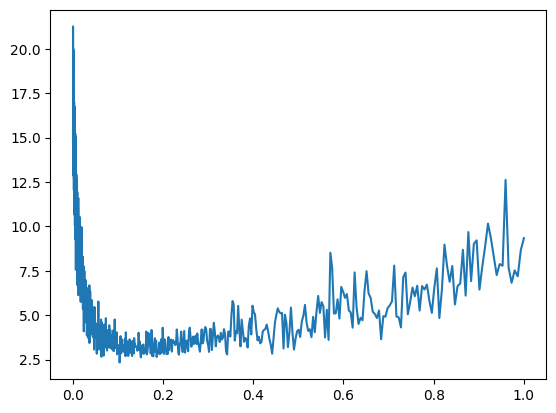

In [ ]:
# liste per registrare il learning rate utilizzato e la perdita per quella iterazione
lri = [] # inizializziamo il learning rate utilizzato con una lista vuota
lossi = [] # inizializziamo la perdita con una lista vuota

for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,)) # il "(32,)" è scritto così perché torch.randint accetta solamente tuple come dimensione del batch

  # forward pass
  emb = C[X[ix]] # verranno selezionati solo gli elementi di X presenti del batch
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # verranno selezionati solo gli elementi di Y presenti del batch
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr) # aggiungiamo il learning rate appena utilizzato
  lossi.append(loss.item()) # aggiungiamo la perdita a fine iterazione

plt.plot(lri, lossi)

Dalla curva si può vedere che, in questo caso, il learning rate più adatto è intorno a `0.1`, in quanto, per valori torppo piccoli c'è poca variazione di punto in punto, mentre per valori superiori la curva inizia a diventare instabile.

Avremmo potuto osservarlo anche tracciando l'esponente (ovvero `lre`, al posto di `lrs`), dopo aver nuovamente resettato i parametri:

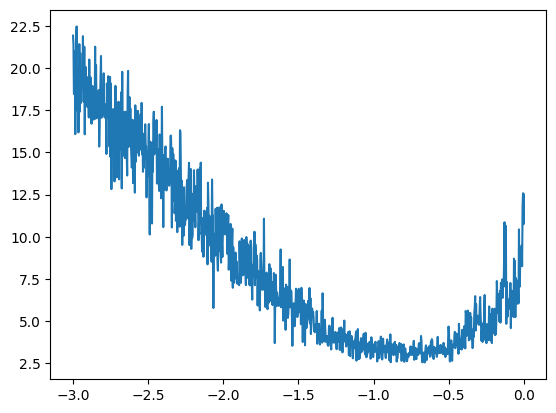

In [ ]:
# liste per registrare il learning rate utilizzato e la perdita per quella iterazione
lri = [] # inizializziamo il learning rate utilizzato con una lista vuota
lossi = [] # inizializziamo la perdita con una lista vuota

for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,)) # il "(32,)" è scritto così perché torch.randint accetta solamente tuple come dimensione del batch

  # forward pass
  emb = C[X[ix]] # verranno selezionati solo gli elementi di X presenti del batch
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # verranno selezionati solo gli elementi di Y presenti del batch
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i]) # aggiungiamo il learning rate appena utilizzato
  lossi.append(loss.item()) # aggiungiamo la perdita a fine iterazione

plt.plot(lri, lossi)

Possiamo vedere che gli esponenti migliori sono intorno al `-1.0`, che corrispondono ad un rate di `0.1`.

<a name="s6.2.1"></a>
#### **6.2.1 - Learning rate decay**

Dopo aver raggiunto un buon livello di perdita con il tasso "ottimale" che abbiamo individuato precedentemente, è possibile ridurre ancora la perdita, riducendo il valore del learning rate ed effettuando qualche ulteriore ciclo di addestramento. 

Questo processo permette di ottenere utleriori miglioramenti, anche dopo che l'addestramento con il tasso precedente ha raggiunto uno stallo.

Possiamo quindi modificare l'addestramento, per fare in modo che un certo numero di cicli venga fatto con il tasso pari a `0.1` e successivamente vengano effettuati altri cicli con un tasso pari a `0.01`

In [ ]:
for i in range(20000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,)) # il "(32,)" è scritto così perché torch.randint accetta solamente tuple come dimensione del batch

  # forward pass
  emb = C[X[ix]] # verranno selezionati solo gli elementi di X presenti del batch
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # verranno selezionati solo gli elementi di Y presenti del batch
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad



<a name="s6.3"></a>
### **6.3 - Scomposizione del dataset in Train, Validation e Test**

Cerchiamo ora di non far accadere il fenomeno dell'overfitting. Addestrare il modello su tutti i dati, e cercando di ridurre la perdita nell'indovinarli, porta il modello a memorizzare tutti i pattern possibili e può portare ad una perdita bassissima, tuttavia, il modello addestrato in questo modo potrebbe non essere capace di prevedere accuratamente dati nuovi, ovvero non presenti sul dataset su cui si è addestrato. Questo fenomeno si verifica tanto più quanto il modello è di grandi dimensioni, in quanto man mano che diventa più potente diventa anche più capace comprendere e memorizzare tutte le relazioni tra i dati, al punto da poterli replicare. Si vedrebbe, infatti, che la perdita che si avrebbe nell'indovinare parole all'interno del dataset di addestramento sarebbe molto bassa, mentre, per parole non presenti nel dataset, molto elevata.

Per risolvere questo problema si può dividere il dataset in 3 split differenti:

1. **Train**: comprende gran parte dei dati, e viene utilizzato per addestrare il modello, che avrà la possibilità diapprendere osservando le etichette. Serve a migliorare i parametri del modello (ad esempio il learning rate).   

2. **Dev/Validation**: è uno split il cui scopo è dare la possibilità di effettuare modifiche agli iperparametri della rete (dimensione dell'hidden layer, dimensione dell'embedding, ecc.).

3. **Test**: split utilizzato per testare le performance del modello dopo che sono stati raggiunti risultati soddisfacenti con i primi due split. La prova con questo split deve essere fatta pochissime volte, in quanto ogni volta che viene valutato il modello su questo split e si impara qualcosa da esso, si sta iniziando sostanzialmente utilizzando questo split come addestramento, rischiando di far overfittare il modello ad esso.

Generalmente una buona suddivisione può essere 80%, 10%, 10%.

Definiamo quindi la funzione che crea i tre differenti datasets:

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# definizione della funzione, che verrà chiamata di seguito per definire i dataset di train dev e test
def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape) # dimensioni di X e Y ad ognuna delle 3 iterazioni (train, dev, test)
  return X, Y

import random
random.seed(42)
random.shuffle(words) # mischia tutte le parole
n1 = int(0.8*len(words)) # 80% delle parole
n2 = int(0.9*len(words)) # 90% delle parole

Xtr, Ytr = build_dataset(words[:n1]) # train da 0 a 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # dev da 80% a 90%
Xte, Yte = build_dataset(words[n2:]) # test da 90% a 100%

print("---")

print(f"Train size = {len(words[:n1])}")
print(f"Dev size = {len(words[n1:n2])}")
print(f"Test size = {len(words[n2:])}")

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])
---
Train size = 25626
Dev size = 3203
Test size = 3204


I primi 3 print forniscono la quantità di esempi contenuti in ciascuno dei tre datasets, i secondi 3 print indicano il numero di parole presenti in ogni dataset.

Adesso possiamo resettare nuovamente la rete, e addestrarla solamente sui dati di train:

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # lista con tutti i parametri

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Aggiungiamo un blocco per poter effettuare le analisi in seguito:

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(100000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 50000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item()) # possiamo utilizzare il logaritmo per vedere meglio i risultati graficamente

#print(loss.item())

2.3384315967559814


Osserviamo graficamente la riduzione della perdita, vedendo il logaritmo per fare in modo che la parte iniziale che è molto alta venga schiacciata, permettendo di vedere meglio il resto:

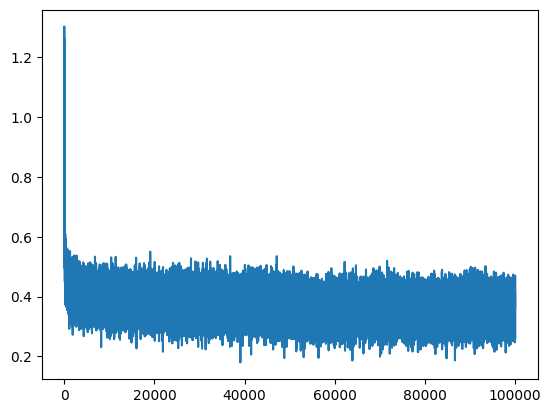

In [ ]:
plt.plot(stepi, lossi)

Possiamo vedere che la perdita ha del rumore, per via dell'utilizzo dei mini batches.

Vediamo la perdita complessiva su tutto il dataset di train (rispetto a considerare solamente i mini batches)

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2913, grad_fn=<NllLossBackward0>)

Ora passiamo ad effettuare la validazione, sul dataset di dev:

In [ ]:
# dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3062, grad_fn=<NllLossBackward0>)

Possiamo vedere che, sebbene la validazione stia venendo fatta sui dati di dev, che la rete non ha mai visto, la differenza tra gli errori è marginale. **Questo vuol dire che il modello non riesce a fare overfitting**, ovvero non è abbastanza potente da apprendere i pattern dei dati. **Ciò ci indica che il modello è ancora migliorabile**, perché se non riesce a causare overfitting vuol dire che un modello che invece ci riesce potrebbe ottenere una perdita ancora più bassa.

Questo è una dimostrazione del motivo per il quale si effettua una prima validazione con i dati di dev. Questa informazione ci fa capire che potremmo modificare gli iperparametri per rendere la rete più potente (ad esempio, aumentando i neuroni dell'hidden layer, oppure aumentando le dimensioni dell'embedding layer, ad esempio da 2 a 3).

Poiché al momento stiamo utilizzando l'embedding layer a due dimensioni, possiamo effettivamente rappresentarlo, per vedere, a seguito dell'addestramento, come sono stati mappati i vari caratteri.

<a name="s6.3.1"></a>
#### **6.3.1 - Grafico della matrice di embedding post addestramento**

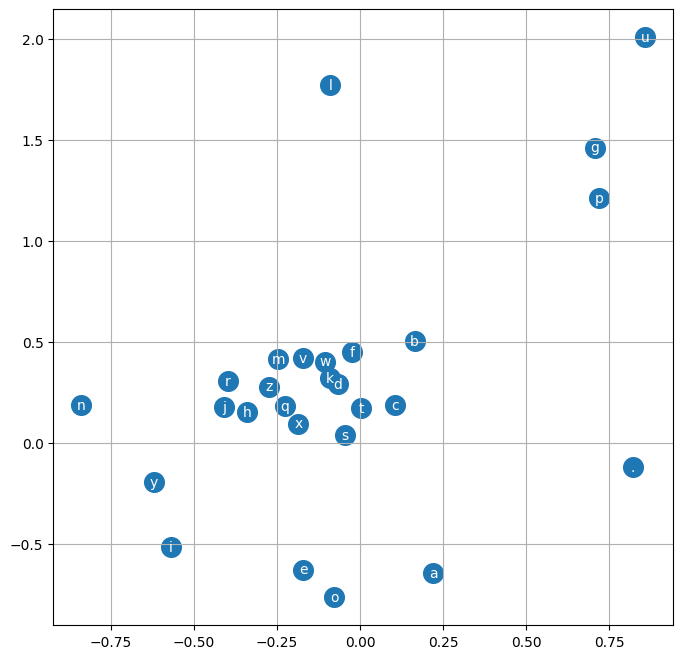

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Il grafico mostra risultati interessanti. Il modello ha imparato a separare i caratteri, clusterizzandoli. Ha imparato che le vocali ed altri caratteri particolari vanno trattate in maniera diversa dalle altre lettere. Alcune vocali sono vicine tra loro, perciò il modello le considera interscambiabili.

Ora proviamo a modificare gli iperparametri e a riaddestrare la rete, per vedere se migliora l'accuratezza e il modello riesce ad imparare meglio dai dati.

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # embedding in un vettore di 10 dimensioni per ogni parola (rispetto a prima che ne erano 2)
W1 = torch.randn((30, 200), generator=g) # 3*10 input (il 3 è dato dalle lettere di contesto), 200 output
b1 = torch.randn(200, generator=g) # hidden layer da 200 neuroni
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # lista con tutti i parametri

Vedaiamo quanti parametri ha ora la rete:

In [ ]:
sum(p.nelement() for p in parameters) # numero di parametri totali

11897

Sono aumentati molto rispetto a prima (che ne erano poco più di 3000)

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(100000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 30 per via delle dimensioni dell'embedding layer (3*10)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 50000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item()) # possiamo utilizzare il logaritmo per vedere meglio i risultati graficamente

#print(loss.item())

In [ ]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1680, grad_fn=<NllLossBackward0>)

In [ ]:
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2041, grad_fn=<NllLossBackward0>)

Come possiamo vedere, già con questi cambiamenti, la perdita sul dataset di train inizia a separarsi da quella sul dataset di test, perciò probabilmente la nostra supposizione che il modello potesse eessere troppo piccolo potrebbe essere corretta.

Per completezza, vediamo l'accuratezza anche sui dati di test.

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2003, grad_fn=<NllLossBackward0>)

<a name="s7"></a>
## **7 - Generazione di nomi**

Infine, possiamo effettuare dei test di generazione di nomi per vedere come performa il modello:

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20): # 20 generazioni

    out = []
    context = [0] * block_size # inizializza con "..."
    while True: # il modello continua a generare finche non genera "0", ovvero "."
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # rende probabilità (con l'esponenziale) e fa in modo che sommano ad 1, e previene problemi allo stesso modo della funzione cross_entropy
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # seleziona dalle varie probabilità
      context = context[1:] + [ix] # viene tagliato il primo elemento del contesto , e si fa l'append con il numero del carattere attuale (quindi per il primo giro in questo esempio si passa da [0, 0, 0] a [0, 0, 5])
      out.append(ix)
      if ix == 0: # condizione per far fermare il ciclo while
        break

    print(''.join(itos[i] for i in out)) # decoding degli indici

mora.
mayah.
seel.
nihah.
lorethrucendraeg.
adeeydeeliigh.
poren.
eden.
sananaraelyn.
malaia.
noshibergihamies.
jenir.
jelionnteron.
ubukahdariyah.
fael.
yuma.
myston.
mahianna.
yansun.
zakelle.


Come possiamo constatare, le generazioni sono decisamente migliori rispetto al Bigram Language Model sviluppato nella lezione precedente.

<a name="s8"></a>
## **Conclusioni**

Questa lezione ci ha permesso di esplorare concetti fondamentali per lo sviluppo di modelli di intelligenza artificiale generativa più sofisticati. In particolare, abbiamo costruito un modello linguistico N-Gram utilizzando una rete neurale di tipo Multi-Layer Perceptron (MLP) per la generazione di nomi, scegliendo arbitrariamente il contesto di caratteri per migliorare la qualità delle previsioni.

Uno dei primi passi è stato l'utilizzo dell'embedding per rappresentare i caratteri. Questa tecnica ha permesso di trasformare i caratteri in vettori, permettendo al modello di catturare relazioni e caratteristiche particolari dei caratteri stessi.

L'addestramento del modello ha mostrato una significativa riduzione della perdita rispetto al modello Bigram, indicando che il modello è riuscito ad apprendere efficacemente le relazioni tra i caratteri.

Un aspetto interessante emerso è l'iniziale assenza di overfitting durante l'addestramento. Ciò ci ha suggerito che il modello non fosse ancora abbastanza potente da catturare completamente le relazioni complesse nei dati. Questa osservazione ci ha portato a considerare la possibilità di modificare gli iperparametri per aumentare la capacità del modello, permettendogli di apprendere più a fondo le strutture presenti nei dati senza causare overfitting. Per fare ciò, è stata essenziale la suddivisione del dataset in train, dev/validation e test. Questa pratica ha permesso di valutare meglio le performance del modello, garantendo inoltre che generalizzi bene su dati non visti.

Abbiamo visto poi come rendere il processo di addestramento più efficiente, utilizzando funzioni di `PyTorch` come `view()` e `cross_entropy()`, e introducendo il concetto di batching, ovvero addestrare il modello solamente su piccole porzioni (random) del dataset iniziale, ad ogni iterazione, permettendo di gestire dataset più grandi e complessi in tempi ragionevoli.

Infine, abbiamo visto come migliorare ancora di più le prestazioni del modello tramite l'introduzione del "learning rate decay", utile a migliorare ulteriormente la convergenza del modello.

La lezione ha fornito una solida base per ulteriori esplorazioni e sviluppi nel campo dell'intelligenza artificiale generativa, aprendo la strada a studi più avanzati.